## Text classification

The process of categorizing text into pre-defined groups/classes:

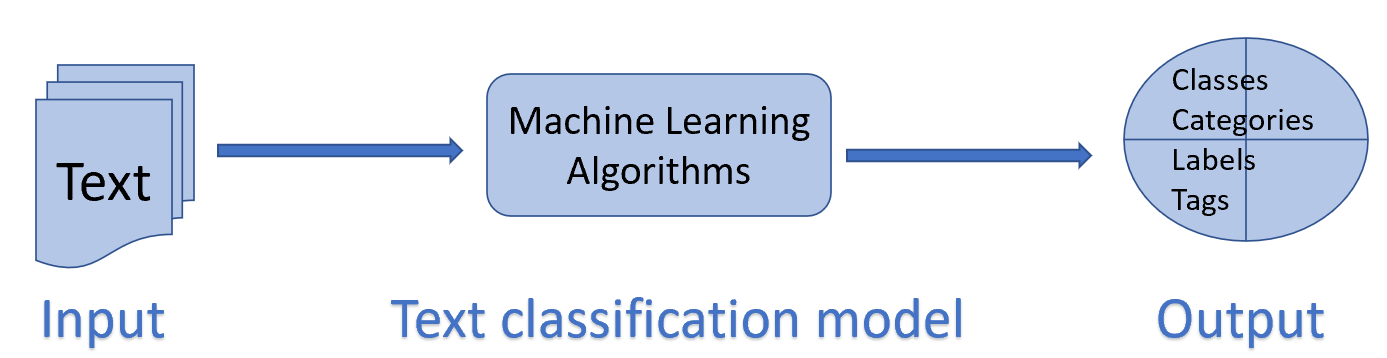

<br>

- **Goal**: organize unstructured text to extract value and get insights into:
    - social media messages
    - emails
    - online conversations (chat-bots)
    - websites


- **Applications**:
    - Sentiment Analysis: understand the view / attitute / feeling / emotion toward a situation or event.
    - Topic Labeling: identify the theme or topic in the text (e.g. analyze the topics of news articles: entertainment, business, politics).
    - Spam Detection: detect whether an email is spam or not.
    - User attribute inference (e.g., infer gender, age, occupation of the author based on his/her posts on social media platforms).


- **Machine Learning based approach**:
    - train a classifier using pre-labeled training data
    - apply the classifier to make predictions on new data
    - pros: fast, effective, accurate
    - cons: need pre-labeled training data

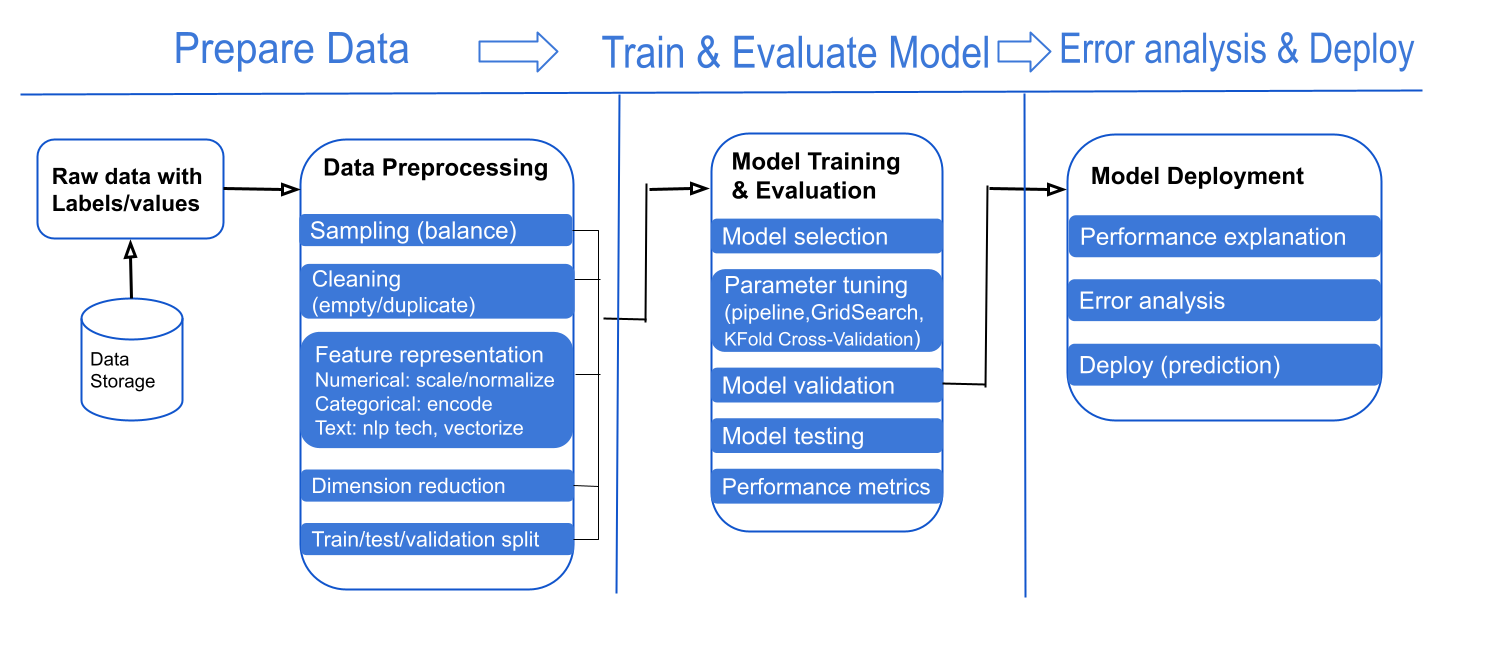

### Binary sentiment classification task for IMDb movie reviews data

- [IMDb](https://www.imdb.com/): Internet Movie Database, online database of information related to films, television programs, and so on.

- Task: train a binary classification model to predict whether a movie review is positive or negative.

- Example: https://www.imdb.com/title/tt0454921/reviews?ref_=tt_urv

<!-- <img src="IMDb_review.png" width="600"> -->

## Import libraries

In [1]:
import time, os

# scientific calculation packages
import numpy as np 
import pandas as pd 
from collections import Counter

# visualization packages
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

# natural language processing packages
import re
from nltk.corpus import stopwords

# machine learning packages
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Load and explore the data
Data source: https://ai.stanford.edu/~amaas/data/sentiment/ <br>
Paper: [Learning Word Vectors for Sentiment Analysis](https://ai.stanford.edu/~ang/papers/acl11-WordVectorsSentimentAnalysis.pdf) <br>

In [2]:
# Read data from csv file to a pandas dataframe
df_data = pd.read_csv('./IMDB Dataset.csv')

# check the data size and display the top-n data samples 
df_data.shape, display(df_data.head())

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


((50000, 2), None)

In [3]:
# you can change parameter setting to view non-truncated dataframe
# pd.set_option('display.max_colwidth', None)

In [4]:
# this is an example of negative review
df_data.iloc[10].sentiment, df_data.iloc[10].review

('negative',
 'Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines.<br /><br />At first it was very odd and pretty funny but as the movie progressed I didn\'t find the jokes or oddness funny anymore.<br /><br />Its a low budget film (thats never a problem in itself), there were some pretty interesting characters, but eventually I just lost interest.<br /><br />I imagine this film would appeal to a stoner who is currently partaking.<br /><br />For something similar but better try "Brother from another planet"')

#### Initial Data Exploration

In [5]:
# check empty cells
df_data.isnull().sum() 

review       0
sentiment    0
dtype: int64

In [6]:
# remove duplicate samples
df_data = df_data.drop_duplicates(keep="first")

# check the number of training samples after remove duplication
# reduce from 50,000 to 49582, we removed about 500 duplicate samples
df_data.shape

(49582, 2)

In [7]:
# check data distribution in each class
df_data.sentiment.value_counts() 

positive    24884
negative    24698
Name: sentiment, dtype: int64

The dataset is equally distributed, which is great for building a ML model.

Now, let's check the length of the reviews

In [8]:
df_data['length'] = df_data['review'].apply(len) # number of characters
df_data['length'].describe() 
# the describe function shows the mean, std, min, max of length of the reviews

count    49582.000000
mean      1310.568230
std        990.762238
min         32.000000
25%        699.000000
50%        971.000000
75%       1592.000000
max      13704.000000
Name: length, dtype: float64

In [9]:
# we have a new column 'length' added to the dataframe
df_data.head(2)

,review,sentiment,length
0,One of the other reviewers has mentioned that ...,positive,1761
1,A wonderful little production. <br /><br />The...,positive,998


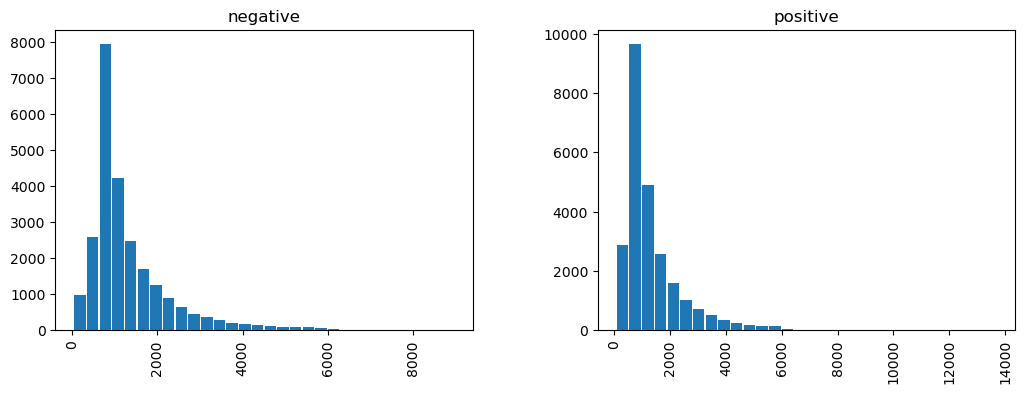

In [10]:
# plot the length of positive and negative reviews
# x: length of reviews; y: number of reviews fall into each interval
df_data.hist(column='length', by='sentiment',bins=30, figsize=(12,4),
             rwidth=0.9)
plt.show()
# adding xlabel, ylabel, title

According to the above distribution, there is no clear difference between postive and negative reviews in terms of review length.

After the initial exploration, we now have a basic understanding of the dataset.
Lets go ahead to process the reviews.

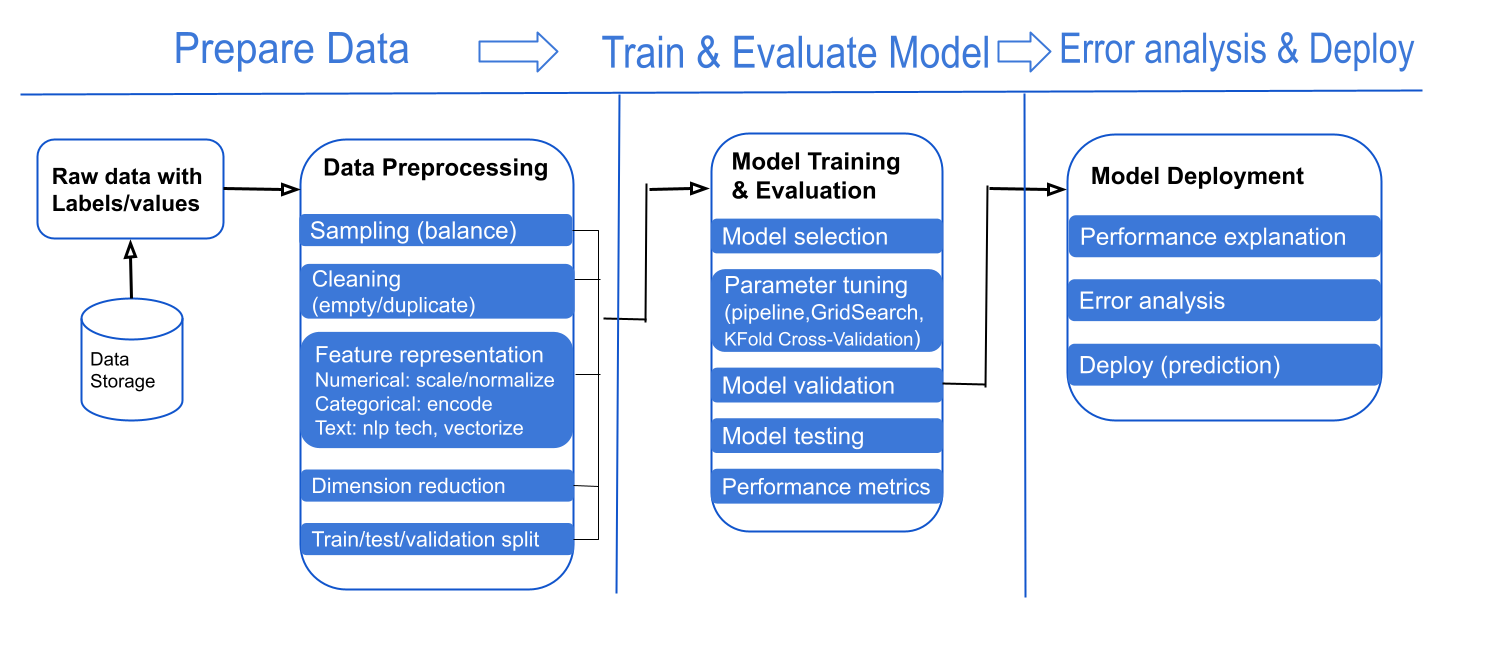

## Data Preprocessing 
In this task, we have text data, so we will focus on text preprocessing. There are many approaches for text preprocessing, such as:
- text cleaning (e.g., remove special characters, emails, urls)
- lowercasing (e.g., Happy New Year -> happy new year)
- remove stopwords
- stemming: chops off the ends of words to transform words into their root forms (e.g., connected->connect)
- lemmatization: map a word to its root form (e.g., interesting -> interest)
- normalization: transforming a text into a standard form (abbreviations, misspellings, out-of-vocabulary words; e.g., gooood->good)
- part-of-speech tagging (e.g., good -> ADJ)

The specific steps to do depends on your task.
For our task of analyzing IMDb movie reviews data, we mainly focus on **text cleaning**, such as removing:

> HTML tags <br>
> special / non-alphabetic characters <br>
> url <br>
> emails <br>

In [11]:
# Here is an example of the review, we can see that ...
df_data.review[5]

'Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but it\'s not preachy or boring. It just never gets old, despite my having seen it some 15 or more times in the last 25 years. Paul Lukas\' performance brings tears to my eyes, and Bette Davis, in one of her very few truly sympathetic roles, is a delight. The kids are, as grandma says, more like "dressed-up midgets" than children, but that only makes them more fun to watch. And the mother\'s slow awakening to what\'s happening in the world and under her own roof is believable and startling. If I had a dozen thumbs, they\'d all be "up" for this movie.'

In [12]:
from tqdm import tqdm
import re, string
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer

In [13]:
def decontracted(phrase):
    """
    Expand the contracted phrase into normal words
    """
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase) # prime 
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    return phrase

def clean_text(df):
    """
    Clean the review texts
    """
    cleaned_review = []

    for review_text in tqdm(df['review']):
        
        # expand the contracted words
        review_text = decontracted(review_text)
        
        #remove html tags
        review_text = BeautifulSoup(review_text, 'lxml').get_text().strip() # re.sub(r'<.*?>', '', text)
        
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
        #remove url 
        review_text = re.sub(r'https?://\S+|www\.\S+', '', review_text)
        
        #Removing punctutation, string.punctuation in python consists of !"#$%&\'()*+,-./:;<=>?@[\\]^_{|}~`
        review_text = review_text.translate(str.maketrans('', '', string.punctuation))
        # ''.join([char for char in movie_text_data if char not in string.punctuation])
        
        # remove emails
        review_text = re.sub(r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)", '', review_text)
    
        cleaned_review.append(review_text)

    return cleaned_review

df_data['cleaned_review'] = clean_text(df_data)
# df_data['cleaned_review'] = df_data.apply(clean_text)
# df_data = df_data.drop(columns=['review'])

df_data.head()
# After the cleaning process, we get the cleaned_reviews

100%|██████████| 49582/49582 [00:06<00:00, 7175.71it/s]


,review,sentiment,length,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,1761,One of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,998,A wonderful little production The filming tec...
2,I thought this was a wonderful way to spend ti...,positive,926,I thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,748,Basically there is a family where a little boy...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317,Petter Mattei is Love in the Time of Money i...


In [14]:
# example of a review before and after cleaning, we can see that the punctuations and html tags are removed.

print(df_data['review'][9],'\n')

print(df_data['cleaned_review'][9])

If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!! 

If you like original gut wrenching laughter you will like this movie  If you are young or old then you will love this movie  hell even my mom liked it Great Camp   


Before moving forward, we convert the sentiments to binary labels (e.g., 1 for postive and 0 for negative).

In [15]:
df_data['label'] = df_data['sentiment'].map({'positive':1,'negative':0})
df_data.head()[['cleaned_review','sentiment','label']]

,cleaned_review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production The filming tec...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there is a family where a little boy...,negative,0
4,Petter Mattei is Love in the Time of Money i...,positive,1


### Text Feature Representation

The process of transforming a collection of texts into numerical feature vectors (vectorization) that the computers can understand.

- Bag-of-words representation: documents are described by word occurrences while completely ignoring the relative position information of the words in the document.
- Vectorization: tokenization, counting, and normalization


**Techniques**:
- documentation:
    > https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

- Units of representation:
    > words <br>
    > ngram / phrases <br>
    > sentences <br>
    > POS tag <br>

- CountVectorizer 
    > represent document as a vector of word counts
- TfidfVectorizer 
    > term-frequency * inverse document-frequency <br>
    > reduce very frequent terms (e.g., 'a', 'the', 'is')
- Embedding 
    > represent words into high-dimensional dense vectors <br>
    > word2vec, BERT, GPT, ...

In [16]:
# you can check the pre-defined English stop words list
# print(stopwords.words('english'))

# define your own stopwords list
# Exluding NO, NOR, NOT from the stop words as they play keyrole
stopwords= list(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])


# In the CountVectorizer, we ask it to lowercase the text, use a self-defined stopwords list to remove stopwords
vectorizer = CountVectorizer(lowercase=True, stop_words=stopwords, max_df=0.9, min_df=3, ngram_range=(1,1))

# convert the cleaned reviews to vectors
X = vectorizer.fit_transform(df_data.cleaned_review)
y = df_data.label.values

print("X.shape : ",X.shape)
print("y.shape : ",y.shape)

# X is the 2-d matrix of vector representation of the cleaned reviews
# y is the array of sentiment labels
# X.shape: the number of samples, the number of features (size of vocabulary)

X.shape :  (49582, 47192)
y.shape :  (49582,)


### Train test split
- Shuffling the data (random permutations of the collections)
- Split the data into training and testing by 80:20 ratio (you can customize the ratio by yourself)
- Assign a random state for reproducible output

In [17]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2,
                                                 shuffle=True,
                                                 random_state=42)
# check data size after splitting
print("Training data: X : {}, y : {}".format(X_train.shape, y_train.shape))
print("Testing data: X : {}, y : {}".format(X_test.shape, y_test.shape))
# For example, after train test split, we get 39665 samples in the training set and 9917 in the testing set.

Training data: X : (39665, 47192), y : (39665,)
Testing data: X : (9917, 47192), y : (9917,)


In [18]:
# check data distribution in train and test

print("Training data distribution", Counter(y_train))
print("Testing data distribution", Counter(y_test))

Training data distribution Counter({1: 19906, 0: 19759})
Testing data distribution Counter({1: 4978, 0: 4939})


An alternative choice if you want to track the train and test index

In [19]:
train_idx, test_idx = train_test_split(np.arange(df_data.shape[0]), test_size=0.2, 
                                       shuffle=True, random_state=42)

len(train_idx), len(test_idx)
print("Number of training examples:{}".format(len(train_idx)))
print("Number of testing examples:{}".format(len(test_idx)))

Number of training examples:39665
Number of testing examples:9917


In [20]:
X_train = X[train_idx]
y_train = y[train_idx]

X_test = X[test_idx]
y_test = y[test_idx]

print("Training data: X_train : {}, y_train : {}".format(X_train.shape, y_train.shape))
print("Testing data: X_test : {}, y_test : {}".format(X_test.shape, y_test.shape))

Training data: X_train : (39665, 47192), y_train : (39665,)
Testing data: X_test : (9917, 47192), y_test : (9917,)


<img src="./pipeline.png" width="600" align="left">

## Train a Machine Learning Model

After we do text preprocessing, text feature representation, and train test split, the next step is model training, we need to decide which model to use. For example, the available binary classification models are:

- Logistic Regression
- Naive Bayes
- Decision Tree
- K-Nearest Neighbors
- Support Vector Machines
- (Deep) Neural Networks
- ... many many more

In this task, we will use **Logistic regression** as an example, which is one of the most popular and interpretable machine learning algorithm for binary classification.

**Logistic Regression**: regression with output constrained between 0 and 1 with a sigmoid logistic function, as we see here, combine the linear regression with a logistic/sigmoid function, we get the logistic regression function:
  
$$ 
    \hat{y} = \frac{1}{1 + \exp (- t)}  = \frac{1}{1 + \exp (-\sum_i\beta_i x_i)} 
$$

- $x_i$ is value of feature $i$ in an instance (word count)<br>
- $\beta_i$ is the model parameter associated with feature $i$ <br>
  - E.g., high $\beta_i$ means feature $i$ is predictive of positive class ($y=1$) <br>
- $\hat{y}$ is the probability of being positive, $y$ is the actual label <br>
    - If $\hat{y} > .5$, classify as positive, $y = 1$ <br>


<!-- <img src="./image/Logistic_curve.png" width="400"> -->

### Parameter tuning with grid search
- Search for the best set of parameters in each step
- In this task, we will do parameter tuning for the following two steps: 
    
> [Countvectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) <br>
> [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

vectorizer = CountVectorizer(lowercase=True, stop_words=stopwords)
logistic = LogisticRegression() 

# build a pipeline
pipe = Pipeline(steps = [
       ('vectorizer', vectorizer),
       ('classifier', logistic)])

# creat a dictionary of model parameters and corresponding values
# E.g., in countvectorizer, we want to explore the suitable value for min_df, select from 1,3,5,10
param_grid = {
    'vectorizer__min_df': [1, 3, 5, 10],
    'vectorizer__max_df': [0.7, 0.8, 0.9],
    'classifier__penalty': ['l1','l2']}


Run GridSearchCV and time it:

In [22]:
# get the running time of a process
start = time.time()
search_result = GridSearchCV(pipe, param_grid, cv=5, scoring='f1').fit(df_data.cleaned_review.values, df_data.label.values)
# scoring: accuracy by default

end = time.time()
print((end-start)/(1000*60)) # milli-seconds: 0.001 second

0.006725364232063293


In [23]:
print(search_result)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer',
                                        CountVectorizer(stop_words=['br', 'the',
                                                                    'i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    

In [24]:
print("Best parameter (CV score=%0.3f):" % search_result.best_score_) 

print(search_result.best_params_)
# with 5 fold cv, the best f1 score is 0.889, and the corresponding parameter values are as follows:

Best parameter (CV score=0.887):
{'classifier__penalty': 'l2', 'vectorizer__max_df': 0.9, 'vectorizer__min_df': 1}


### Model Validation
- k-fold cross-validation 
> train on k-1 folds, test on 1 fold, repeat k times <br>
> each instance appears only once in test set <br>

- We've done cross validation in GridSearchCV, so we can skip it.
- But if you still want to check the overall model performance on the whole dataset, here are the following steps to perform cross validation:
> Create a model (e.g., LogisticRegression, you can apply the best model parameters reported in GridSearchCV) <br>
> Pass the model and the whole data (i.e., X, y) to do cross validation <br>
> Print out the n-fold cross validation results <br>

In [25]:
from sklearn.model_selection import cross_val_score

In [26]:
vectorizer = CountVectorizer(lowercase=True, max_df=0.9, min_df=1)

# convert the cleaned reviews to vectors
X = vectorizer.fit_transform(df_data.cleaned_review)
y = df_data.label.values

print("X.shape : ",X.shape)
print("y.shape : ",y.shape)

X.shape :  (49582, 102292)
y.shape :  (49582,)


In [27]:
lr_clf = LogisticRegression(penalty='l2')
scores = cross_val_score(lr_clf, X, y, cv=5, scoring='precision')
print(scores)

[0.88492063 0.88310139 0.88762475 0.87605745 0.89006808]


In [28]:
df_data.head()

,review,sentiment,length,cleaned_review,label
0,One of the other reviewers has mentioned that ...,positive,1761,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,positive,998,A wonderful little production The filming tec...,1
2,I thought this was a wonderful way to spend ti...,positive,926,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,negative,748,Basically there is a family where a little boy...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317,Petter Mattei is Love in the Time of Money i...,1


## Model evaluation on test data
After we select the specific model and find the best set of model parameters, we are now going to evaluate model performance on test set. 

- [Scoring metrics](https://scikit-learn.org/stable/modules/model_evaluation.html)

- Confusion matrix <br>

- Classification report: <br>
    > Do train/test split with a specified ratio (e.g., 7:3 or 8:2) <br>
    > Train the model on the training data <br>
    > Evaluate model performance on the testing data <br>
    > Print out classification report (precision, recall, f1) <br>

- roc_auc <br>

In [29]:
# fit a logistic regression classifier on the training data 
lr_clf = LogisticRegression(penalty='l2')
lr_clf.fit(X_train, y_train)

LogisticRegression()

In [30]:
# make prediction on testing data
y_pred_test = lr_clf.predict(X_test)
y_pred_test

array([0, 1, 0, ..., 0, 0, 0])

In [31]:
# check the predicted probabilities on each test data
y_predprob_test = lr_clf.predict_proba(X_test)
y_predprob_test

array([[9.99962640e-01, 3.73603888e-05],
       [9.43306725e-05, 9.99905669e-01],
       [9.87025608e-01, 1.29743925e-02],
       ...,
       [9.99930738e-01, 6.92619837e-05],
       [9.98008862e-01, 1.99113802e-03],
       [8.54168430e-01, 1.45831570e-01]])

In [32]:
print(classification_report(y_test, y_pred_test))
# micro average (averaging the total true positives, false negatives and false positives globally, true pos of one class / (all true pos + all false pos))
# macro average (averaging the unweighted mean per label)

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4939
           1       0.88      0.89      0.88      4978

    accuracy                           0.88      9917
   macro avg       0.88      0.88      0.88      9917
weighted avg       0.88      0.88      0.88      9917



- ROC curve

In [33]:
from sklearn.metrics import roc_curve, auc

In [34]:
fpr, tpr, thresholds = roc_curve(y_true = y_test, y_score = y_predprob_test[:,1], pos_label=1)
roc_auc = auc(fpr, tpr) # area under ROC curve

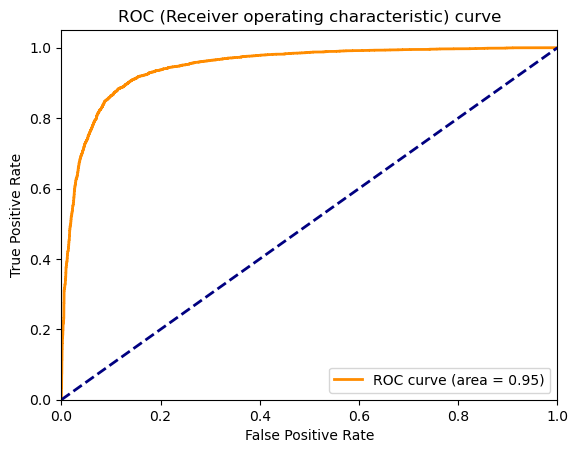

In [35]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (Receiver operating characteristic) curve')
plt.legend(loc="lower right")
plt.show()

According to the evaluation scores we can say that the model is performing good.

## Explain the model performance
- Check the top features that are predictive of positive sentiments and negative sentiments
- Check the reviews that the model fails to predict its true sentiment

Are the top predictive features make sense to you?

In [36]:
feature_names = vectorizer.get_feature_names_out()
#feature_to_coef = {word: float("%.3f" % coef) for word, coef in zip(vectorizer.get_feature_names(), lr_clf.coef_[0])}
feature_to_coef = {word: float("%.3f" % coef) for word, coef in zip(feature_names, lr_clf.coef_[0])}

In [37]:
print("Top positive features:")
sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:10]
# Here is the list of top-10 words with high positive coefficients
# words like "refreshing, hooked, superb" are reliable evidence of indicating positive sentiments

Top positive features:


[('brinkmanship', 2.053),
 ('freiwald', 2.018),
 ('cowriter', 1.806),
 ('heroistic', 1.589),
 ('itfa', 1.529),
 ('inarticulate', 1.468),
 ('borrowed', 1.442),
 ('cavalryman', 1.438),
 ('carosine', 1.424),
 ('faggus', 1.419)]

In [38]:
# Here is the list of top-10 words with high negative coefficients
# most of the words are reliable evidence of indicating negative sentiments
print("Top negative features:")
sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=False)[:10]

Top negative features:


[('involuntary', -2.244),
 ('incubating', -2.205),
 ('jaane', -2.146),
 ('ciano', -1.961),
 ('dupe', -1.955),
 ('brioche', -1.907),
 ('hazels', -1.803),
 ('cochlea', -1.724),
 ('burrier', -1.7),
 ('amedia', -1.681)]

**Note**: using feature coefficient to indicate predictive feature for each class is only suitable when your feature matrix are all positive (e.g., binary CountVectorizer).

### Error analysis 
- Samples where the model fails to predict its true sentiment

In [39]:
df_test = df_data.iloc[test_idx]
df_test['pred_label'] = y_pred_test
df_test.head(3)[['review','label','pred_label']]

,review,label,pred_label
29171,"""Soul Plane"" is a horrible attempt at comedy t...",0,0
43589,Guest from the Future tells a fascinating stor...,1,1
38712,"""National Treasure"" (2004) is a thoroughly mis...",0,0


In [40]:
df_test[df_test['label'] != df_test['pred_label']].head()[['review','label','pred_label']]

,review,label,pred_label
47783,His significant charisma and commanding presen...,0,1
40146,A horror movie is being shot and things aren't...,1,0
42907,There is only one racist joke in this Daffy Du...,1,0
43156,I've been a classic horror fan my entire life....,0,1
8304,I acquired this film a couple of years ago and...,0,1


In [41]:
df_data.loc[47783]['cleaned_review']

'His significant charisma and commanding presence are about all that keep this afloat  but Fred Williamson has done far better urban action films including many of his later  vid released fare  The big studios  Williamson films of the early to mid    is rarely had the punch of their mid level counterparts  and this is a prime example  Clumsy action  little violence  and the PG rating is nowhere near questionable  Worth a look for Hammer completists in any case '

In [42]:


#analysis = []
#for wd in df_data.loc[47783]['cleaned_review'].split():
#    if wd in vectorizer.vocabulary_:
#        wd_id = vectorizer.vocabulary_[wd]
#        analysis.append(wd+'('+("%.3f" % lr_clf.coef_[0][wd_id])+')')
#    else:
#        analysis.append(wd)
#        
#print(' '.join(analysis))

#Debugging 
#print("Vocabulary Size during Training:", len(vectorizer.vocabulary_))
#print("Vocabulary Size during Prediction:", len(lr_clf.coef_[0]))


In [43]:
default_coefficient = 0.0  # Choose an appropriate default coefficient

analysis = []
for wd in df_data.loc[47783]['cleaned_review'].split():
    if wd in vectorizer.vocabulary_:
        wd_id = vectorizer.vocabulary_[wd]
        
        # Check if the index is within the bounds
        if wd_id < len(lr_clf.coef_[0]):
            analysis.append(wd + '(' + ("%.3f" % lr_clf.coef_[0][wd_id]) + ')')
        else:
            analysis.append(wd + '(Invalid Index)')
    else:
        analysis.append(wd + '(' + ("%.3f" % default_coefficient) + ')')

print(' '.join(analysis))



His(0.000) significant(Invalid Index) charisma(0.001) and(0.000) commanding(0.294) presence(Invalid Index) are(-0.094) about(0.521) all(-0.049) that(Invalid Index) keep(Invalid Index) this(0.000) afloat(0.111) but(-0.113) Fred(0.000) Williamson(0.000) has(0.009) done(-0.182) far(-0.022) better(-0.126) urban(Invalid Index) action(0.154) films(0.022) including(-0.415) many(Invalid Index) of(0.000) his(0.021) later(Invalid Index) vid(Invalid Index) released(Invalid Index) fare(0.002) The(0.000) big(0.001) studios(Invalid Index) Williamson(0.000) films(0.022) of(0.000) the(0.000) early(-0.031) to(0.000) mid(Invalid Index) is(0.000) rarely(Invalid Index) had(0.001) the(0.000) punch(Invalid Index) of(0.000) their(Invalid Index) mid(Invalid Index) level(Invalid Index) counterparts(0.017) and(0.000) this(0.000) is(0.000) a(0.000) prime(Invalid Index) example(-0.564) Clumsy(0.000) action(0.154) little(Invalid Index) violence(Invalid Index) and(0.000) the(0.000) PG(0.000) rating(Invalid Index) i

<img src="./pipeline.png" width="600" align="left">

## Conclusion

In this task, we build a binary sentiment classifier for IMDb movie reviews dataset.<br> 
- **Data preprocessing**: we first explore and cleaned the data, and then use CountVectorizer to convert the texts into 2d feature matrix.<br> 
- **Model selection and parameter tuning**: we use GridSearchCV to explore the best parameter settings for CountVectorizer and LogisticRegression in this task.
- **Model evaluation**: we split the data into 80% training and 20% testing, and train a LogisticRegression classifier on the training data (with the best parameter setting) and evaluate model performance on the testing data. We report the model performance using precision (88%), recall(88%), f1, and roc_auc (0.95). <br>
- **Model explanation**: we checked the top coefficient words to explain the model performance.
- **Error analysis**: we do error analysis by explaining samples where the model make errors.